Authors: 

    Bernarndo Vicente 202008545
    Miguel Gouveia    202302221

Software Versions:
 - Python 3.11.11
 - msclap 1.3.3
 - torch 2.1.2
 - pandas 2.2.3
 - numpy 1.26.4
 - tqdm 4.67.1
 - matplotlib 3.9.4
 - seaborn 0.13.2

This notebook makes zero-shot predictions using a CLAP model from 2023. The data set used is the US8K dataset.

The notebook saves the predictions made in a pickle file so the predictions only need to be made once. This is due to the fact that the prediction making of the whole dataset can take around 25 mins depending on the hardware.

If the file "y_preds.pkl" contains the predictions made, the flag/option MAKE_PREDICTIONS can be set to False and the notebook should still run as intended

Imports for Zero-Shot Classification

In [1]:
from msclap import CLAP
import torch.nn.functional as F
from torch import tensor
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Notebook OPTIONS

In [2]:
MAKE_PREDICTIONS = False

Load and Initialize a CLAP model

In [3]:
clap_model = CLAP(version = '2023', use_cuda=False)

Get US8K metadata

In [4]:
metadata_path = '../dataset/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadata_path)

Set Up Data Set and Labels for Zero-Shot Classification

In [5]:
dataset_root_path = '../dataset/UrbanSound8K/audio/'

file_names = metadata['slice_file_name']

file_folds = metadata['fold']

file_labels = metadata['class']

file_paths = []

# Define class descriptions
labels = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"]

y_labels = []

for file_fold, file_name, file_label in zip(file_folds, file_names, file_labels):
    file_paths.append(f"{dataset_root_path}fold{file_fold}/{file_name}")
    
    aux_array = tensor(np.zeros((1,len(labels)), dtype=np.float32))
    if file_label in labels:
        index = labels.index(file_label)
        aux_array[0, index] = 1.0
        y_labels.append(aux_array.detach().cpu().numpy())
    else:
        print(f"File label: {file_label} not found in label list!")


Get Text Embbedings

In [6]:
prompt = 'this is the sound of '
y = [prompt + x for x in labels]

text_embeddings = clap_model.get_text_embeddings(y)

Make Zero-Shot Predictions

In [7]:
if MAKE_PREDICTIONS:
    y_preds = []
    for i in tqdm(range(len(file_paths))):
        x = file_paths[i]
        audio_embeddings = clap_model.get_audio_embeddings([x], resample=True)
        similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)
        y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
        y_preds.append(y_pred)
else:
    # Load the predictions from the file
    with open('y_preds.pkl', 'rb') as file:
        y_preds = pickle.load(file)

Save Predictions

In [8]:
# Save the predictions to a file
with open('y_preds.pkl', 'wb') as file:
    pickle.dump(y_preds, file)

Accuracy

In [9]:
conc_y_preds = np.concatenate(y_preds, axis=0)
conc_y_labels = np.concatenate(y_labels, axis=0)
acc = accuracy_score(np.argmax(conc_y_labels, axis=1), np.argmax(conc_y_preds, axis=1))

print(f'US8K Accuracy {acc * 100} %')

US8K Accuracy 81.04672469079249 %


Confusion Matrix

In [10]:
# Convert y_labels (true labels) from one-hot to class indices
true_classes = np.array([np.argmax(label) for label in y_labels])

# Convert y_preds (predicted probabilities) to class indices
predicted_classes = np.array([np.argmax(pred) for pred in y_preds])

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[770   0  57   0   3  79   0  11   9  71]
 [  9 301   0   0   0  12   1  14  22  70]
 [  3   0 958   0   4   4   0   0   4  27]
 [ 37   0  71 852   1   4   0   4   8  23]
 [ 55   2  10   0 644  85   0 184   6  14]
 [123  12   4   0   0 806   0  30   2  23]
 [  0   0   0   0   0   1 359  13   0   1]
 [ 63   0   0   0  30  45   0 810   0  52]
 [ 14   0  13   0   0   7   0   1 785 109]
 [  9   0 177   0   0   6   0   0  16 792]]


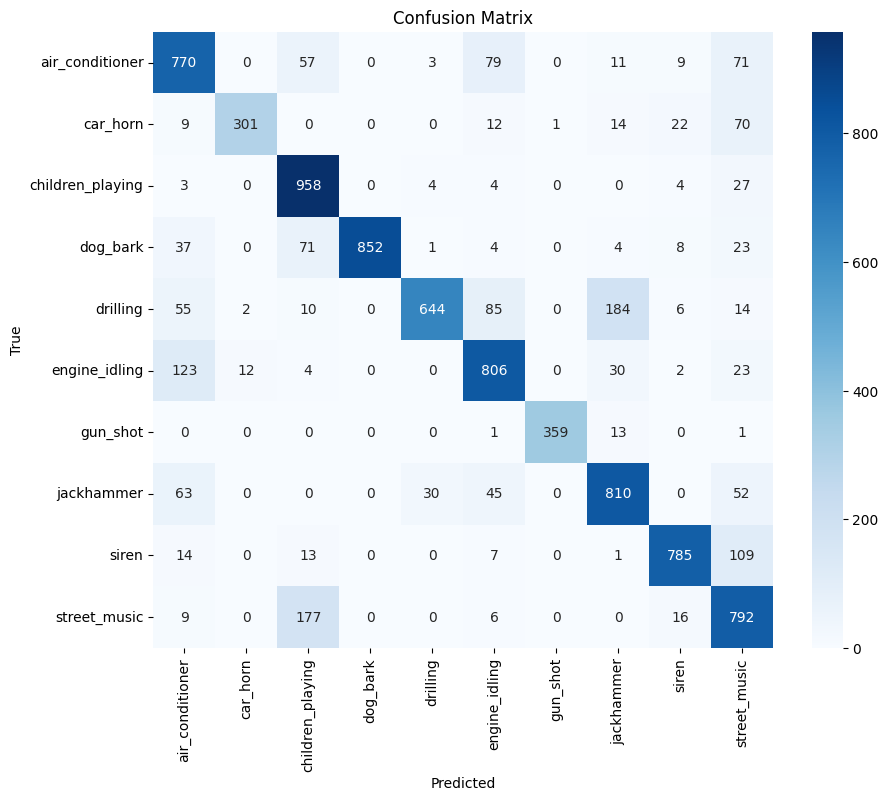

In [11]:
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()